# Compute the median normalised RF distance of FULL dataset

In [1]:
"""
Batch U-test on normalized RF distances (single model, many RNA families).

For each RNA directory under DIR_RF:
  • Read DNA↔DNA       matrix: <RNA>.raxml.rfdist         (10×10)
  • Read DNA↔RNA (Pi)  matrix: <RNA>.raxml.raxmlPi.rfdist (10×10)
  • Normalize each cell to nRF = RF / [2*(n-3)]  (auto-skips if already ≤1)
  • DNA↔DNA: use upper triangle (k=1) → 45 values
    DNA↔RNA: use all 100 values
  • Compute two-sided Mann–Whitney U-test
  • Record per-RNA medians for both groups
Outputs:
  1) Utest_long.csv        : Model, RNA, n_DNA, n_RNA, U, pvalue, p_bonf, flags
  2) Utest_wide.csv        : RNA × Model table of (raw) p-values
  3) Median_nRF_long.csv   : long table of per-RNA medians (for plotting)
Notes:
  • n = #taxa is taken from a tree file per RNA. We try, in order:
      <RNA>.raxml  →  <RNA>.raxmlPi  →  any DNA tree in DIR_DNA/<RNA>/RAxML_bestTree.*
"""

import os
from os.path import join, isdir
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import normalize as _ignore   # not used; kept to show change
from Bio import Phylo

# ── PATHS (EDIT THESE) ─────────────────────────────────────────────────────────
DIR_WORKING = "/Users/u7875558/RNAPhylo/fullAlignment_S6A"
DIR_OUTPUTS = join(DIR_WORKING, "outputs")
DIR_RF      = join(DIR_OUTPUTS, "Robinson_Foulds_iqtree3")   # contains <RNA> subfolders
DIR_DNA     = join(DIR_OUTPUTS, "DNAtrees")                  # fallback place to find a DNA tree
MODEL       = "S6A"                                          # label for outputs

# File suffixes we expect inside each RNA folder
DNA_RFDIST_SUFFIX       = ".raxml.rfdist"        # DNA vs DNA
DNA_VS_RNA_IPSEU_SUFFIX = ".raxml.raxmlPi.rfdist"  # DNA vs RNA (ignore pseudoknots)

# ── OPTIONS ────────────────────────────────────────────────────────────────────
ALPHA = 0.05          # nominal alpha
DO_BONFERRONI = True  # set False to skip adjusted p-values

# ── Helpers ────────────────────────────────────────────────────────────────────
def read_rfdist_matrix(path: str) -> np.ndarray:
    """Read IQ-TREE .rfdist into a 2D array of floats. Returns empty array if nothing."""
    with open(path, "r") as f:
        lines = f.readlines()
    if len(lines) <= 1:
        return np.array([])
    rows = []
    for line in lines[1:]:
        parts = line.strip().split()
        if len(parts) <= 1:
            continue
        rows.append(list(map(float, parts[1:])))  # skip the row label
    return np.array(rows, dtype=float) if rows else np.array([])

def find_one_tree_for_taxa(rna_dir: str, rna: str, dir_dna: str) -> str | None:
    """
    Return a path to any tree file for this RNA to count taxa from.
    Priority: <rna_dir>/<RNA>.raxml → <rna_dir>/<RNA>.raxmlPi → DIR_DNA/<RNA>/RAxML_bestTree.*
    """
    candidates = [
        join(rna_dir, f"{rna}.raxml"),
        join(rna_dir, f"{rna}.raxmlPi"),
    ]
    dna_rna_dir = join(dir_dna, rna)
    if isdir(dna_rna_dir):
        # Pick first DNA tree file found
        for fn in sorted(os.listdir(dna_rna_dir)):
            if fn.startswith("RAxML_bestTree"):
                candidates.append(join(dna_rna_dir, fn))
                break
    for p in candidates:
        if os.path.exists(p):
            return p
    return None

def count_taxa(tree_path: str) -> int | None:
    """Count terminals in the first tree from a Newick file."""
    try:
        with open(tree_path, "r") as fh:
            tree = next(Phylo.parse(fh, "newick"))
        return len(tree.get_terminals())
    except Exception:
        return None

def normalize_rf_matrix_by_n(mat: np.ndarray, n_taxa: int) -> np.ndarray:
    """
    Standard RF normalization to [0,1]:
      nRF = RF / (2*(n-3))  for unrooted binary trees.
    If max(mat) ≤ 1.0, assume already normalized; return as-is.
    """
    if mat.size == 0:
        return mat
    if np.nanmax(mat) <= 1.0 + 1e-9:
        return mat.copy()
    denom = 2 * (n_taxa - 3)
    if denom <= 0:
        return mat   # degenerate; return raw to avoid division by zero
    return mat / denom

def upper_triangle_values(mat: np.ndarray) -> np.ndarray:
    """Return the upper triangle (k=1) flattened; empty if invalid."""
    if mat.size == 0:
        return np.array([])
    n = mat.shape[0]
    iu = np.triu_indices(n, k=1)
    return mat[iu].astype(float)

# ── Core per-RNA computation ───────────────────────────────────────────────────
def process_one_rna(rna_dir: str, rna: str) -> dict | None:
    """
    Read, normalize, summarize, and U-test one RNA.
    Returns a dict of results, or None if cannot process.
    """
    dna_fp   = join(rna_dir, f"{rna}{DNA_RFDIST_SUFFIX}")
    ipseu_fp = join(rna_dir, f"{rna}{DNA_VS_RNA_IPSEU_SUFFIX}")
    if not (os.path.exists(dna_fp) and os.path.exists(ipseu_fp)):
        return None

    # Determine n from any available tree
    tree_path = find_one_tree_for_taxa(rna_dir, rna, DIR_DNA)
    if tree_path is None:
        return None
    n_taxa = count_taxa(tree_path)
    if not n_taxa or n_taxa < 4:
        return None

    # Read matrices and normalize by 2*(n-3) (unless already 0..1)
    dna_raw   = read_rfdist_matrix(dna_fp)
    ipseu_raw = read_rfdist_matrix(ipseu_fp)
    if dna_raw.size == 0 or ipseu_raw.size == 0:
        return None

    dna_nrf   = normalize_rf_matrix_by_n(dna_raw,   n_taxa)
    ipseu_nrf = normalize_rf_matrix_by_n(ipseu_raw, n_taxa)

    dna_vals   = upper_triangle_values(dna_nrf)    # 45 values
    rna_vals   = ipseu_nrf.flatten().astype(float) # 100 values
    if dna_vals.size == 0 or rna_vals.size == 0:
        return None

    # U-test (two-sided)
    try:
        res = mannwhitneyu(dna_vals, rna_vals, alternative="two-sided")
        U = float(getattr(res, "statistic", res[0]))
        p = float(getattr(res, "pvalue",    res[1]))
    except Exception:
        return None

    return {
        "Model": MODEL,
        "RNA": rna,
        "n_taxa": int(n_taxa),
        "n_DNA":  int(dna_vals.size),
        "n_RNA":  int(rna_vals.size),
        "DNA_median_nRF": float(np.median(dna_vals)),
        "RNA_median_nRF": float(np.median(rna_vals)),
        "U": U,
        "pvalue": p,
    }

# ── Driver ─────────────────────────────────────────────────────────────────────
def main():
    if not isdir(DIR_RF):
        raise SystemExit(f"DIR_RF not found: {DIR_RF}")

    results = []
    rna_dirs = [d for d in sorted(os.listdir(DIR_RF)) if isdir(join(DIR_RF, d))]
    for i, rna in enumerate(rna_dirs, 1):
        rec = process_one_rna(join(DIR_RF, rna), rna)
        if rec:
            results.append(rec)
        # simple heartbeat each 200 RNAs
        if i % 200 == 0:
            print(f"Processed {i}/{len(rna_dirs)} RNAs...")

    if not results:
        print("No usable RNA folders found.")
        return

    df_long = pd.DataFrame(results).sort_values(["RNA"]).reset_index(drop=True)

    # Bonferroni (within this one model)
    if DO_BONFERRONI:
        m = len(df_long)
        df_long["p_bonf"]   = (df_long["pvalue"] * m).clip(upper=1.0)
        df_long["sig_bonf"] = df_long["p_bonf"] < ALPHA
        print(f"Bonferroni significant @ {ALPHA}: {int(df_long['sig_bonf'].sum())} / {m}")

    # Wide p-value table (RNA × Model) — useful even for one model
    df_wide = (
        df_long.pivot(index="RNA", columns="Model", values="pvalue")
               .sort_index()
    )

    # Long table of per-RNA medians for plotting
    med_rows = []
    for _, r in df_long.iterrows():
        med_rows.append({"Model": r["Model"], "RNA": r["RNA"], "Category": "DNA vs DNA", "Median nRF": r["DNA_median_nRF"]})
        med_rows.append({"Model": r["Model"], "RNA": r["RNA"], "Category": "DNA vs RNA", "Median nRF": r["RNA_median_nRF"]})
    df_medians = pd.DataFrame(med_rows)

    # Write outputs
    os.makedirs(DIR_RF, exist_ok=True)
    tag = f"Utest_normRF_{MODEL}"

    return df_long, df_wide, df_medians

if __name__ == "__main__":
    df_long, df_wide, df_medians = main()

Processed 200/2828 RNAs...
Processed 400/2828 RNAs...
Processed 600/2828 RNAs...
Processed 800/2828 RNAs...
Processed 1000/2828 RNAs...
Processed 1200/2828 RNAs...
Processed 1400/2828 RNAs...
Processed 1600/2828 RNAs...
Processed 1800/2828 RNAs...
Processed 2000/2828 RNAs...
Processed 2200/2828 RNAs...
Processed 2400/2828 RNAs...
Processed 2600/2828 RNAs...
Processed 2800/2828 RNAs...
Bonferroni significant @ 0.05: 2244 / 2828


In [2]:
df_medians

,Model,RNA,Category,Median nRF
0,S6A,RF00001,DNA vs DNA,0.600406
1,S6A,RF00001,DNA vs RNA,0.756592
2,S6A,RF00002,DNA vs DNA,0.581489
3,S6A,RF00002,DNA vs RNA,0.698189
4,S6A,RF00003,DNA vs DNA,0.583501
...,...,...,...,...
5651,S6A,RF04302,DNA vs RNA,0.200000
5652,S6A,RF04303,DNA vs DNA,0.285714
5653,S6A,RF04303,DNA vs RNA,0.607143
5654,S6A,RF04310,DNA vs DNA,0.000000


## Figures of median nRF

/var/folders/7l/28yzqfm93j105y85x5rns4bryc93vy/T/ipykernel_72597/3118146754.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


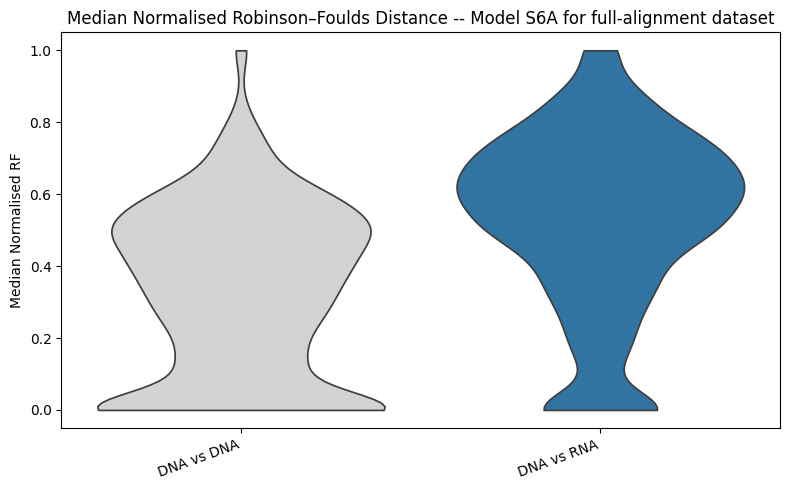

Group medians:
Category
DNA vs DNA    0.3520
DNA vs RNA    0.5714
Name: Median nRF, dtype: float64

Group means:
Category
DNA vs DNA    0.3283
DNA vs RNA    0.5243
Name: Median nRF, dtype: float64


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# We’ll plot only these two categories from this table
order = ['DNA vs DNA', 'DNA vs RNA']

# Keep only rows we need and drop any NaNs in the y column
df_plot = (
    df_medians[df_medians['Category'].isin(order)]
      .copy()
      .dropna(subset=['Median nRF'])
)

# Colors: light gray for DNA vs DNA; pick a distinct color for DNA vs RNA
palette = {
    'DNA vs DNA': 'lightgray',
    'DNA vs RNA': '#1f77b4',  # blue; change if you prefer another color
}

# Compute a little headroom for the y-axis
#ymax = df_plot['Median nRF'].max()

plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df_plot,
    x='Category',
    y='Median nRF',
    order=order,
    palette=palette,
    cut=0,        # don’t extend beyond the data; keeps bottom at 0 cleanly
    inner=None    # no internal box/median lines
)

#plt.ylim(0, ymax * 1.15)   # bottom pinned at 0; top auto with headroom
plt.xticks(rotation=20, ha='right')
plt.title('Median Normalised Robinson–Foulds Distance -- Model S6A for full-alignment dataset')
plt.ylabel('Median Normalised RF')
plt.xlabel('')
plt.tight_layout()
plt.show()

# (optional) print quick summaries
print("Group medians:")
print(df_plot.groupby('Category')['Median nRF'].median().round(4))
print("\nGroup means:")
print(df_plot.groupby('Category')['Median nRF'].mean().round(4))

/var/folders/7l/28yzqfm93j105y85x5rns4bryc93vy/T/ipykernel_72597/3388958417.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


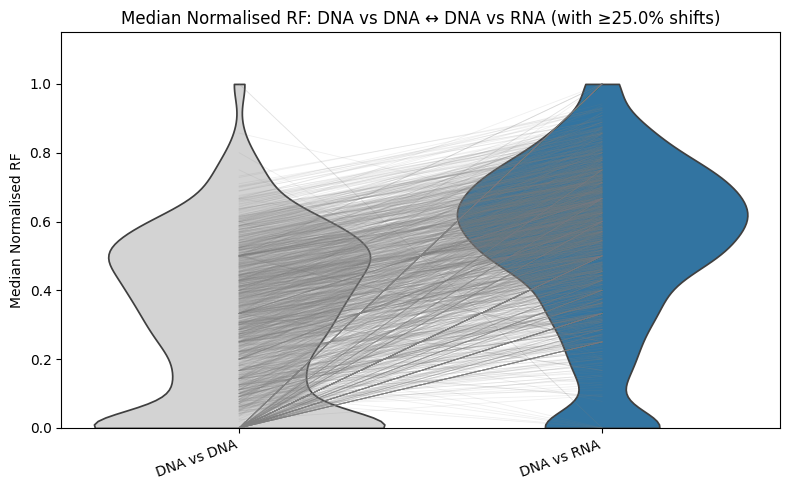

Lines drawn (≥25% change): 1752 / 2828


In [17]:
# --- keep only the two categories we care about ---
order = ['DNA vs DNA', 'DNA vs RNA']
df_plot = (
    df_medians[df_medians['Category'].isin(order)]
      .copy()
      .dropna(subset=['Median nRF'])
)

# --- colors ---
palette = {
    'DNA vs DNA': 'lightgray',   # baseline
    'DNA vs RNA': '#1f77b4',     # blue
}

# --- figure: violins first ---
ymax = df_plot['Median nRF'].max()
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df_plot,
    x='Category',
    y='Median nRF',
    order=order,
    palette=palette,
    cut=0,          # trim to actual min/max (bottom pinned at 0 by ylim below)
    inner=None
)

# --- connecting lines: only if >=10% relative change after rounding ---
THRESHOLD = 0.25   # 10%
ROUND = 3          # round to 3 decimals before comparing

# pivot to wide so each RNA has both values on one row
wide = (
    df_plot.pivot(index='RNA', columns='Category', values='Median nRF')
           .reindex(columns=order)
)

lines_drawn = 0
for rna, row in wide.iterrows():
    v1, v2 = row['DNA vs DNA'], row['DNA vs RNA']
    if pd.isna(v1) or pd.isna(v2):
        continue
    # round to stabilize tiny numerical noise
    v1r, v2r = np.round(v1, ROUND), np.round(v2, ROUND)

    # relative change vs baseline (handle zero safely)
    if v1r > 0:
        rel = abs(v2r - v1r) / v1r
    else:
        rel = abs(v2r - v1r)  # fall back to absolute difference

    if rel >= THRESHOLD:
        plt.plot(
            [0, 1], [v1r, v2r],
            color='gray', alpha=0.12, linewidth=0.6, zorder=2
        )
        lines_drawn += 1

plt.ylim(0, ymax * 1.15)
plt.xticks(rotation=20, ha='right')
plt.title(f'Median Normalised RF: DNA vs DNA ↔ DNA vs RNA (with ≥{THRESHOLD*100}% shifts)')
plt.ylabel('Median Normalised RF')
plt.xlabel('')
plt.tight_layout()
plt.show()

print(f"Lines drawn (≥{int(THRESHOLD*100)}% change): {lines_drawn} / {wide.dropna().shape[0]}")

## p Values of nRF distances

In [18]:
df_long

,Model,RNA,n_taxa,n_DNA,n_RNA,DNA_median_nRF,RNA_median_nRF,U,pvalue,p_bonf,sig_bonf
0,S6A,RF00001,496,45,100,0.600406,0.756592,0.0,6.716883e-22,1.899535e-18,True
1,S6A,RF00002,500,45,100,0.581489,0.698189,0.0,6.844822e-22,1.935716e-18,True
2,S6A,RF00003,500,45,100,0.583501,0.717304,0.0,6.624723e-22,1.873472e-18,True
3,S6A,RF00004,500,45,100,0.734406,0.841046,0.0,6.668194e-22,1.885765e-18,True
4,S6A,RF00006,500,45,100,0.513078,0.659960,0.0,6.826582e-22,1.930557e-18,True
...,...,...,...,...,...,...,...,...,...,...,...
2823,S6A,RF04299,30,45,100,0.370370,0.629630,19.0,4.593063e-22,1.298918e-18,True
2824,S6A,RF04300,6,45,100,0.000000,0.333333,0.0,3.669289e-33,1.037675e-29,True
2825,S6A,RF04302,23,45,100,0.200000,0.200000,2055.0,3.936696e-01,1.000000e+00,False
2826,S6A,RF04303,31,45,100,0.285714,0.607143,0.0,2.593456e-22,7.334293e-19,True


In [19]:
df_long[df_long['sig_bonf']==True]

,Model,RNA,n_taxa,n_DNA,n_RNA,DNA_median_nRF,RNA_median_nRF,U,pvalue,p_bonf,sig_bonf
0,S6A,RF00001,496,45,100,0.600406,0.756592,0.0,6.716883e-22,1.899535e-18,True
1,S6A,RF00002,500,45,100,0.581489,0.698189,0.0,6.844822e-22,1.935716e-18,True
2,S6A,RF00003,500,45,100,0.583501,0.717304,0.0,6.624723e-22,1.873472e-18,True
3,S6A,RF00004,500,45,100,0.734406,0.841046,0.0,6.668194e-22,1.885765e-18,True
4,S6A,RF00006,500,45,100,0.513078,0.659960,0.0,6.826582e-22,1.930557e-18,True
...,...,...,...,...,...,...,...,...,...,...,...
2822,S6A,RF04298,17,45,100,0.285714,0.714286,2.0,3.619972e-23,1.023728e-19,True
2823,S6A,RF04299,30,45,100,0.370370,0.629630,19.0,4.593063e-22,1.298918e-18,True
2824,S6A,RF04300,6,45,100,0.000000,0.333333,0.0,3.669289e-33,1.037675e-29,True
2826,S6A,RF04303,31,45,100,0.285714,0.607143,0.0,2.593456e-22,7.334293e-19,True
